In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from pydiffmap import diffusion_map as dm
import statsmodels.api as sm

#import umap.umap_ as umap

In [2]:
# ============================================================
# 1. CONFIGURATION
# ============================================================

# Path to your Excel file
CSV_PATH = "T24S12-04_E-AL2889.csv"       # <-- change this
#SHEET_NAME = 0                      # sheet index or name, e.g. "Race1"

# If your Excel has a time column or index, put its name here
TIME_COLUMN = "datetime"                  # e.g. "time" or None if no special column

# Number of KPCA components you want
N_COMPONENTS = 7

In [3]:
# ============================================================
# 2. LOAD DATA FROM EXCEL
# ============================================================

# Read Excel
df = pd.read_csv(CSV_PATH)

print("Original columns:", df.columns.tolist())
print("Data shape (rows, cols):", df.shape)

# If there is a time / lap index column you don't want as feature:
if TIME_COLUMN is not None and TIME_COLUMN in df.columns:
    time_index = df[TIME_COLUMN].values
    df = df.drop(columns=[TIME_COLUMN])
else:
    time_index = np.arange(len(df))  # simple index

# Keep only numeric columns (drop text, IDs, etc.)
df_numeric = df.select_dtypes(include=[np.number]).copy()
print("Numeric data shape:", df_numeric.shape)

# Optionally drop rows with too many NaNs
df_numeric = df_numeric.dropna(axis=0)
print("After dropping NaNs, shape:", df_numeric.shape)

X = df_numeric.values  # numpy array (n_samples x n_features)
print(df_numeric)

Original columns: ['datetime', 'nwl1', 'nwl2', 'nwl3', 'nwl4', 'fprd1', 'fprd2', 'fprd3', 'fprd4', 'pstr1', 'pstr3', 'astrw', 'g2', 'ny', 'vcrf', 'v2']
Data shape (rows, cols): (9788, 16)
Numeric data shape: (9788, 15)
After dropping NaNs, shape: (9788, 15)
         nwl1     nwl2     nwl3     nwl4    fprd1    fprd2    fprd3    fprd4  \
0     1879.15  1991.72  1967.96  1939.05  4214.96  4078.38  5893.55  5546.70   
1     1874.40  1984.64  1967.96  1947.37  4162.80  3911.46  5877.12  5757.24   
2     1878.20  1987.00  1964.68  1943.21  2846.01  3042.11  6209.04  7288.14   
3     1882.00  1994.08  1969.05  1944.25  3708.41  3716.73  6946.83  7292.73   
4     1874.40  1988.18  1966.86  1947.37  3685.23  3207.87  7756.92  8256.12   
...       ...      ...      ...      ...      ...      ...      ...      ...   
9783  1902.90  2020.04  2000.74  1968.15  4284.51  3699.34  7089.78  7862.52   
9784  1900.05  2020.04  1990.90  1970.23  3614.52  4143.28  7032.27  8176.04   
9785  1907.65  2020.04

In [4]:
# ============================================================
# 3. SCALE / STANDARDIZE SENSORS
# ============================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled data shape:", X_scaled.shape)

Scaled data shape: (9788, 15)


# PCA

In [6]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)   # (n_samples, 3)

# ---- Interactive 3D scatter in browser ----
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2", "PCA3"])
df_pca["t"] = range(len(df_pca))
fig = px.scatter_3d(
    df_pca,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    color = 't',
    size = 't',
    size_max = 18,
    opacity=0.7
)

fig.update_layout(title="PCA – components 1, 2, 3 (interactive)")
fig.show(renderer="browser")  # opens a new browser window/tab

# Kernel PCA

PCA est évidemment utile pour la réduction de dimension grâce à sa simplicité et le temps de calcul. Pourtant les variables sont supposés linéairement corrélées, ce qui n'est pas toujours le cas, surtout dans notre projet quand on a des relations non-linéaires. Une autre manière à faire est d'utiliser les méthodes de réduction de dimension $\textbf{non-linéaires}$, notamment $\textbf{kernel PCA}$, $\textbf{Isomap}$ ou $\textbf{Diffusion map}$. Parmis elles, Kernel PCA est le plus souvent utilisée.

L'idée de cette méthode est de projeter les données dans une espace de haute dimension par une transformation non-linéaire, et on espère que lespoints se regroupent plus clairement. Puis on va 'appliquer le PCA', en utilisant le $\textbf{kernel trick}$ qui nous permet d'obtenir les coordonnées sans calculer explicitement la grosse matrice de covariance. La question à poser est quel noyau à employer, et comment évaluer ses parametres. 

Une fois qu'on réussit à calculer les coordonnées sur le nouvel espace, on peut détecter les anomalies par plusieurs méthodes, notamment le Hotteling's T2 ou la statistique Q

In [7]:
# 4. ESTIMATE GAMMA FROM FULL DATA (NO SUBSAMPLING)
#    sigma = median pairwise distance on ALL rows
# ============================================================

# pairwise distances for all samples (full NxN)
dists = pairwise_distances(X_scaled, metric="euclidean")

# upper triangle distances (ignore diagonal)
triu_idx = np.triu_indices_from(dists, k=1)
dvals = dists[triu_idx]

sigma = np.median(dvals)
gamma = 1.0 / (2.0 * sigma**2)

print(f"Estimated sigma (full data): {sigma:.4f}")
print(f"Using gamma: {gamma:.6f}")

Estimated sigma (full data): 4.9744
Using gamma: 0.020206


In [8]:
# ============================================================
# 5. RUN KERNEL PCA
# ============================================================

kpca = KernelPCA(
    n_components=N_COMPONENTS,
    kernel="rbf",
    gamma=gamma,
    fit_inverse_transform=False,   # True if you later want approx reconstruction
    eigen_solver="auto",           # let sklearn choose
)

X_kpca = kpca.fit_transform(X_scaled)   # shape: (n_samples, N_COMPONENTS)
print("KPCA scores shape:", X_kpca.shape)

KPCA scores shape: (9788, 7)


In [9]:
#Command pour comprendre les attributs de cette fonction
#help(kpca)

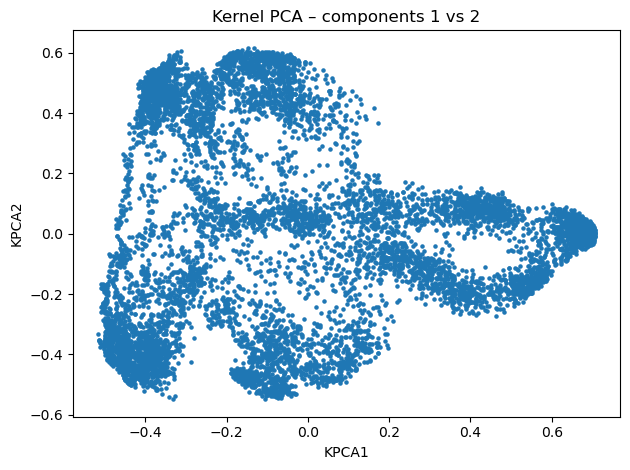

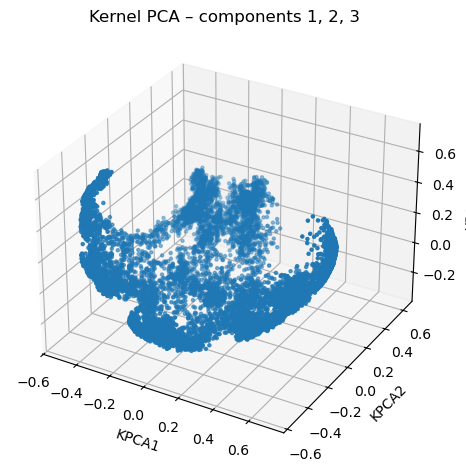

In [10]:
# ============================================================
# 6. SIMPLE PLOTS (KPCA1 vs KPCA2, KPCA1 vs KPCA3, etc.)
# ============================================================

if N_COMPONENTS >= 2:
    plt.figure()
    plt.scatter(X_kpca[:, 0], X_kpca[:, 1], s=5)
    plt.xlabel("KPCA1")
    plt.ylabel("KPCA2")
    plt.title("Kernel PCA – components 1 vs 2")
    plt.tight_layout()
    plt.show()

if N_COMPONENTS >= 3:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X_kpca[:, 0], X_kpca[:, 1], X_kpca[:, 2], s=5)
    ax.set_xlabel("KPCA1")
    ax.set_ylabel("KPCA2")
    ax.set_zlabel("KPCA3")
    ax.set_title("Kernel PCA – components 1, 2, 3")
    plt.tight_layout()
    plt.show()

T² outliers: 98
[1548 1643 1779 2408 7953 7954 7998 7999 8000 8001 8002 8431 8432 8449
 8455 8456 8461 8463 8466 8467 8468 8471 8472 8473 8474 8475 8476 8477
 8478 8479 8480 8481 8482 8483 8484 8485 8486 8488 8489 8491 8492 8493
 8494 8495 8496 8497 8498 8499 8500 8501 8502 8503 8504 8505 8506 8507
 8508 8509 8510 8511 8512 8513 8514 8515 8516 8517 8518 8519 8520 8521
 8522 8523 8524 8525 8526 8527 8528 8530 8531 8532 8533 8534 8535 8536
 8537 8538 8540 8541 8543 8544 8545 8546 8547 8548 8549 8553 8561 8565]


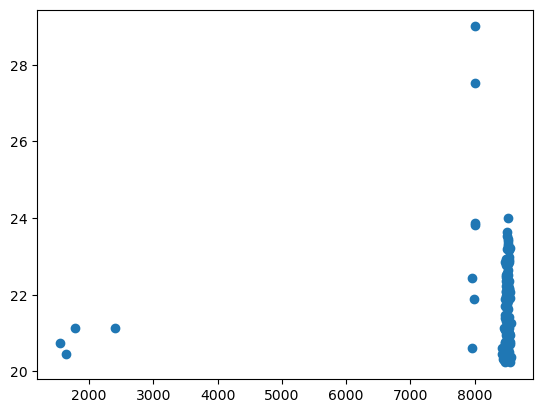

In [11]:
scores = X_kpca   # (n_samples, n_components)

# standardize each KPCA component
scores_std = (scores - scores.mean(axis=0)) / scores.std(axis=0)

# squared distance from origin in KPCA space
T2 = np.sum(scores_std**2, axis=1)

# choose a threshold, e.g. 99th percentile
thr_T2 = np.quantile(T2, 0.99)

outliers_T2 = T2 > thr_T2          # boolean mask
idx_out_T2 = np.where(outliers_T2)[0]
print("T² outliers:", len(idx_out_T2))
print(idx_out_T2)
plt.scatter(idx_out_T2, T2[idx_out_T2])
plt.show()

In [12]:
#Visualization 3D
df_kpca = pd.DataFrame(X_kpca[:, :3], columns=["KPCA1", "KPCA2", "KPCA3"])
df_kpca["t"] = range(len(df_kpca))
df_kpca["T2_outlier"] = np.where(outliers_T2, "outlier", "normal")
# if you have labels per point (lap, race, class, etc.), add them:
# df_kpca["label"] = labels_vector

fig = px.scatter_3d(
    df_kpca,
    x="KPCA1",
    y="KPCA2",
    z="KPCA3",
    #color="T2_outlier",
    color="t",
    size = 't',
    size_max = 18,
    opacity=0.5
)

fig.update_layout(title="Kernel PCA – interactive 3D")
fig.show(renderer="browser")

In [13]:
print(X_kpca)

[[ 0.36651449  0.10517056 -0.09229403 ... -0.12473621  0.12480056
  -0.01895565]
 [ 0.37778608  0.0610987  -0.13024314 ... -0.04918925  0.1244564
  -0.01986797]
 [ 0.36446206  0.06189826 -0.1463982  ... -0.07597771  0.02781004
   0.01143002]
 ...
 [ 0.43566042  0.11753627  0.0073334  ... -0.12910174  0.0261447
   0.06201636]
 [ 0.41965899  0.10701425 -0.05585796 ... -0.1041355  -0.01051089
   0.06682833]
 [ 0.4238879   0.05930108 -0.10126869 ... -0.03327534 -0.00085933
   0.0492365 ]]


In [14]:
print(kpca.eigenvalues_)

[1385.97037351 1024.48679626  417.28430336  310.08854466  169.62393534
   89.10157267   78.25125518]


In [15]:
print(kpca.eigenvectors_)

[[ 9.84496486e-03  3.28579902e-03 -4.51811830e-03 ... -9.57742966e-03
   1.32212908e-02 -2.14285641e-03]
 [ 1.01477318e-02  1.90888055e-03 -6.37586084e-03 ... -3.77682321e-03
   1.31848301e-02 -2.24598962e-03]
 [ 9.78983451e-03  1.93386091e-03 -7.16670784e-03 ... -5.83368011e-03
   2.94617805e-03  1.29211549e-03]
 ...
 [ 1.17022976e-02  3.67213567e-03  3.58995935e-04 ... -9.91262191e-03
   2.76975298e-03  7.01068802e-03]
 [ 1.12724821e-02  3.34340076e-03 -2.73444429e-03 ... -7.99567699e-03
  -1.11351734e-03  7.55466005e-03]
 [ 1.13860753e-02  1.85271833e-03 -4.95745950e-03 ... -2.55492954e-03
  -9.10370031e-05  5.56597868e-03]]


# Isomap

Au lieu de calculer la distance euclidienne entre les points, cette méthode se base sur le $\textit{neighborhood graph}$, cad 2 points sont liées (avoir un chemin qui les connecte) si sa distence euclidienne est plus petite qu'un seuil à définir, ou si l'un est parmis les $\textbf{K}$ plus proches de l'autre. Ensuite on calcule le chemin le plus court entre des points (par l'algo de Dijkstra par ex) pour créer une matrice de distance géodésique. Les vecteurs propres (associés aux valeurs propres les plus grandes) sont les nouveaux variables dans l'espace latent. En fait, cette distance géodésique peut être considérée comme un noyau, donc on peut dire que c'est un cas particulier de Kernel PCA

La question est de choisir K ou choisir le rayon approprié.

In [39]:
def run_isomap(X_scaled, n_components=3, n_neighbors=20):
    iso = Isomap(
        n_neighbors=n_neighbors,
        n_components=n_components
    )
    X_iso = iso.fit_transform(X_scaled)
    return X_iso

In [40]:
X_iso = run_isomap(X_scaled)

In [41]:
df_iso  = pd.DataFrame(X_iso , columns=["Dim 1", "Dim 2", "Dim 3"])
df_iso["t"] = range(len(df_iso))
fig = px.scatter_3d(
    df_iso ,
    x="Dim 1",
    y="Dim 2",
    z="Dim 3",
    color = 't',
    size = 't',
    size_max = 18,
    opacity=0.7
)

fig.update_layout(title="isomap – components 1, 2, 3 (interactive)")
fig.show(renderer="browser")  # opens a new browser window/tab

# Diffusion map

In [45]:
def choose_eps_knn(X, k=50, w_target=0.1):
    n = X.shape[0]
    Xs = X
    nn = NearestNeighbors(n_neighbors=k+1).fit(Xs)
    dists, _ = nn.kneighbors(Xs)
    d_k = dists[:, -1]        # distance to k-th neighbour
    d_med = np.median(d_k)

    # want exp(-d_med^2 / eps) ≈ w_target  (e.g. 0.1)
    eps = d_med**2 / np.log(1.0 / w_target)
    return eps

In [49]:
def run_diffusion_map(X_scaled, n_components=3, mode = 'median'):
    # Gaussian kernel bandwidth using median heuristic
    if mode == 'median':
        D = pairwise_distances(X_scaled, metric='euclidean')
        eps = np.median(D)**2
    elif mode == 'knn':
        eps = choose_eps_knn(X_scaled)

    eps = eps*10
    mydmap = dm.DiffusionMap.from_sklearn(
        n_evecs=n_components,
        epsilon=eps,
        alpha=0.5,   # symmetric normalization → often numerically nicer
        k=50
    )
    return mydmap.fit_transform(X_scaled)

In [50]:
X_dmap = run_diffusion_map(X_scaled, n_components=3)

In [51]:
df_dmap  = pd.DataFrame(X_dmap , columns=["Dim 1", "Dim 2", "Dim 3"])
df_dmap["t"] = range(len(df_dmap))
fig = px.scatter_3d(
    df_dmap ,
    x="Dim 1",
    y="Dim 2",
    z="Dim 3",
    color = 't',
    size = 't',
    size_max = 18,
    opacity=0.7
)

fig.update_layout(title="Difusion map – components 1, 2, 3 (interactive)")
fig.show(renderer="browser")  # opens a new browser window/tab

# Dynamic factor model

In [144]:
df = pd.DataFrame(X_scaled, columns=[f"s{i}" for i in range(X_scaled.shape[1])])
mod = sm.tsa.DynamicFactor(
    df,
    k_factors=2,
    factor_order=1,
    error_cov_type='diagonal'  # idiosyncratic errors are uncorrelated
)

res = mod.fit(method='powell', disp=False)  # or method='lbfgs'
print(res.summary())

                                                                  Statespace Model Results                                                                 
Dep. Variable:     ['s0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14']   No. Observations:                 9788
Model:                                                                           DynamicFactor(factors=2, order=1)   Log Likelihood              -40104.653
Date:                                                                                             Sat, 15 Nov 2025   AIC                          80307.307
Time:                                                                                                     16:56:42   BIC                          80659.563
Sample:                                                                                                          0   HQIC                         80426.670
                                                                

In [145]:
factors = res.factors.filtered  # shape: (k_factors, T)
factors = factors.T  

In [146]:
y_pred = res.predict()            # same shape as df
resid = df - y_pred               # residuals

# Aggregate residuals across sensors
resid_norm = np.linalg.norm(resid.values, axis=1)

thr = np.quantile(resid_norm, 0.99)
is_out_dfm = resid_norm > thr

In [147]:
def plot_factor_timeseries_interactive(factors, t=None, title="Dynamic factors vs time"):
    T, k = factors.shape
    if t is None:
        t = np.arange(T)

    fig = go.Figure()
    for i in range(k):
        fig.add_trace(
            go.Scattergl(
                x=t,
                y=factors[:, i],
                mode="lines",
                name=f"Factor {i+1}"
            )
        )

    fig.update_layout(
        title=title,
        xaxis_title="time",
        yaxis_title="factor value"
    )
    fig.show(renderer="browser")

plot_factor_timeseries_interactive(factors)
